### TFG - Cesar Hernandez Rodriguez
Quintos pasos en las redes neuronales y la bolsa, para este caso buscamos predecir valores de cierre de diferentes activos. Este script es una ema de lo que se busca en el TFG, tiene limitacion de activos de los cuales todos se predicen de una forma correcta con minimo 200 epocas.

Este script se basa en descargar datos de la bolsa de EEUU, exactamente todos los del índice NASDAQ que es uno de los índices más importantes de Estados Unidos (índide tecnologico), siendo la segunda bolsa de valores automatizada y electronica mas grande del mundo con 3800 compañias. (https://es.wikipedia.org/wiki/NASDAQ)

De este conjunto de datos solo voy a coger son $['IIIN', 'PRGX', 'UNFI', 'EBIO', 'MINI', 'SNCR', 'USAP', 'JMBA', 'NTLS', 'FDML']$ de los cuales $NTLS$ no cumple la condicion de que tenga datos para el test en las fechas deseadas y $FDML$ tiene pocos datos para el conjunto test

Para ello usaré la librería QUANDL (https://www.quandl.com/tools/python) que implementa una API para poder descargar los datos de manera sencilla. Al crearme una cuenta gratuita las opciones que se ofrecen no son las mias que para una cuenata premium por lo que cogere fechas pasadas y no actuales. 

A mayores una vez descagardo los datos (ya que tarda mucho) los voy a guardar dentro de mi ordenador serializandolo con el paquete Pickle (http://pyspanishdoc.sourceforge.net/lib/module-pickle.html)

In [1]:
# Import predefinifods
import pandas as pd
import numpy as np
import random
from math import *
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from time import time
import matplotlib.pyplot as plt
from collections import Counter

# Importa descaga de datos
import quandl

# Import serializar
import pickle

# Import red Neuronal
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
# Tengo dos .csv con todos los tickers que me guarda la API de Quandl y en otro con los tickers que quiero usar
# para esta demo, comparo si estan todos y los pongo en formato de descarga (WIKI/ticker)
def get_tickers_sample_nasdaq():
    tickers_wiki_quandl = pd.read_csv('WIKI_PRICES.csv')['ticker']
    tickers_nasdaq = pd.read_csv('nasdaq-funciona.csv')['Symbol']
    
    tickersQuandl = []    
    tickers = []
    for i in range(len(tickers_nasdaq)):
        word = tickers_nasdaq[i]
        for j in range(len(tickers_wiki_quandl)):
            if word == tickers_wiki_quandl[j]:
                tickers.append(word)
    
    for tick in tickers:
        tickersQuandl.append("WIKI/"+tick)
    
    return tickers, tickersQuandl

# a,b = get_tickers_sample_nasdaq()

In [3]:
# Descargo los datos de la API Quandl, para ello uso el conjunto de datos que me ofrece WIKI/ que se puede ver
# en la página de la libreria y me registro en la pagina de forma gratuita dandome una key.
# me devuelve una lista con todos los datos posibles de ese activo, yo guardo todos y por separado los de cierre
# Aunque solo me interese los de cierre quiero guardar todos los datos por si en una extension de este trabajo se queire 
# usar cualquier otro dato
# Para no tener que realizar la parte de descarga cada vez que se inicia el programa se ha habilitado la descarga
# y guardado de datos en una carpeta datos que ya debe crearse antes. Los datos se guardan serializados.

def get_data(verbose):
    quandl.ApiConfig.api_key = 'WgQVD8Npfox1MN7SV3Nm'
    tickers, tickersQuandl = get_tickers_sample_nasdaq()
    
    if verbose: print(" ****Empezamos a descargar los datos****\n")
    
    datos = {}
    start_time = time()
    long = len(tickersQuandl)
    i = 0
    # Las fechas elegidas son esas para poder tener una gran cantidad de datos historicos y
    # que justo se complementen con las fechas de tipo test, al hacer Medias Moviles se pierden muchos datos
    for ticker in tickersQuandl:
        if i % 2 == 0 and verbose: print("LLeva descargados el ",i/long *100,"% de los datos")
        aux=quandl.get(ticker,start_date="2000-01-01",end_date="2016-12-31")
        datos[ticker[5:len(ticker)]] = aux
        i = i + 1
    
    datosClose = {}
    for key in datos:
        datosClose[key] = datos[key]["Adj. Close"]
    
    elapsed_time = time() - start_time
    if verbose: print("\nHa tardado en descargar los datos: %0.10f segundos." % elapsed_time)
    
    if verbose: print("\n ****Empezamos a descargar los datos test****\n")
    
    # Procedo a hacer las mismas operaciones para el conjunto TEST
    datos_test = {}
    i = 0
    long = len(tickersQuandl)
    start_time = time()    
    for ticker in tickersQuandl:
        if i % 2 == 0 and verbose: print("LLeva descargados el ",i/long *100,"% de los datos test")
        aux=quandl.get(ticker,start_date="2016-11-16",end_date="2020-12-31")
        datos_test[ticker[5:len(ticker)]] = aux
        i = i + 1
    
    datosClose_test = {}
    for key in datos_test:
        datosClose_test[key] = datos_test[key]["Adj. Close"]
    
        elapsed_time = time() - start_time
    if verbose: print("\nHa tardado en descargar los datos test: %0.10f segundos." % elapsed_time)
    if verbose: print("\n")
    
    # Solo cogemos los datos que nos da la aplicacion
    # ya que hay activos que no tenemos su valor en esas fechas o tenemos muy pocos datos

    quitar = []
    for key in tickers:
        if datosClose_test[key].empty:
            if verbose == True : print("Restriccion de vacio",key) 
            datos.pop(key,None)
            datosClose.pop(key,None)
            datos_test.pop(key,None)
            datosClose_test.pop(key,None)
            quitar.append(key)
        elif len(datosClose_test[key]) < 300:
            if verbose == True :  print("Restriccion de longitud",key)
            datos.pop(key,None)
            datosClose.pop(key,None)
            datos_test.pop(key,None)
            datosClose_test.pop(key,None)
            quitar.append(key)
            
    for key in quitar:
        tickers.remove(key)
    
    # Guardamos los datos y serializamos
    pickle.dump(tickers, open("datos_demo/tickers_nasdaq.p", "wb"))
    pickle.dump(tickersQuandl, open("datos_demo/tickersQuandl_nasdaq.p", "wb"))
    pickle.dump(datos, open("datos_demo/nasdaq.p", "wb"))
    pickle.dump(datosClose, open("datos_demo/nasdaqClose.p", "wb"))
    pickle.dump(datos_test, open("datos_demo/nasdaq_test.p", "wb"))
    pickle.dump(datosClose_test, open("datos_demo/nasdaqClose_test.p", "wb"))
    
    return tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test

In [4]:
# Si los datos ya han sido descargados con esta funcion los cargo gracias a la libreria pickles
def get_data_load(verbose):
    if verbose: print(" ****Empezamos a cargar los datos****\n")
    tickers = pickle.load(open("datos_demo/tickers_nasdaq.p", "rb" ))
    tickersQuandl = pickle.load(open("datos_demo/tickersQuandl_nasdaq.p", "rb" ))
    datos = pickle.load(open("datos_demo/nasdaq.p", "rb" ))
    datosClose = pickle.load(open("datos_demo/nasdaqClose.p", "rb" ))
    if verbose: print(" ****Cargados los datos****\n")
    
    if verbose: print("\n ****Empezamos a cargar los datos test****\n")
    datos_test = pickle.load(open("datos_demo/nasdaq_test.p", "rb" ))
    datosClose_test = pickle.load(open("datos_demo/nasdaqClose_test.p", "rb" ))
    if verbose: print(" ****Cargados los datos test****\n")
    
    return tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test

# Para imprimir cualquier conjunto tipo Serie temporal del conjunto de datos base uso esta funcion
def plot_datos(datosClose,nombre,test):
    datosClose[nombre].plot(figsize=(12,5),grid=True)
    plt.title('{} {}\n'.format(nombre,test))
    plt.ylabel('Precio de Cierre')
    plt.xlabel('Fecha')
    plt.show()
    

In [5]:
datos_descargados = False
if datos_descargados:
    tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test= get_data_load(True)
else : 
    tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test = get_data(True)

 ****Empezamos a descargar los datos****

LLeva descargados el  0.0 % de los datos
LLeva descargados el  20.0 % de los datos
LLeva descargados el  40.0 % de los datos
LLeva descargados el  60.0 % de los datos
LLeva descargados el  80.0 % de los datos

Ha tardado en descargar los datos: 21.0883452892 segundos.

 ****Empezamos a descargar los datos test****

LLeva descargados el  0.0 % de los datos test
LLeva descargados el  20.0 % de los datos test
LLeva descargados el  40.0 % de los datos test
LLeva descargados el  60.0 % de los datos test
LLeva descargados el  80.0 % de los datos test

Ha tardado en descargar los datos test: 5.4327390194 segundos.


Restriccion de vacio NTLS
Restriccion de longitud FDML


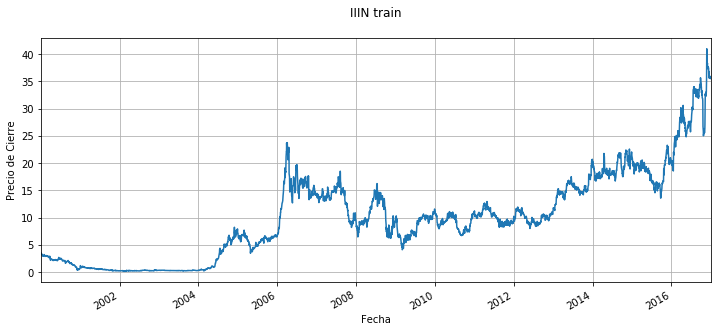

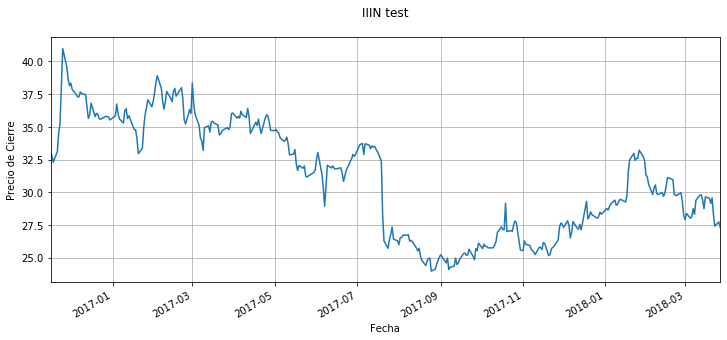

In [6]:
# Grafico un activo aleatorio que luego predecire
# Se tiene el gráfico con el que se creara el modelo y los datos sobre los que se va a testear
ran = random.randint(0,len(tickers)-1)
plot_datos(datosClose,tickers[ran],"train")
plot_datos(datosClose_test,tickers[ran],"test")

In [7]:
# Para crear los atributos que voy a meter en la red Neuronal uso esta funcion, mis atributos son
# Dos medias moviles, una de 30 dias y otra de 15 para hacer la simulacion con los datos de un mes y la mitad de mes
# por ulitmo creo un oscilador de la media movil de 30 dias donde resto los valores son separacion de 30 dias
def differences(x):
    return x[-1] - x[0]

def create_features(datosClose,days1,days2):
    X = pd.DataFrame()
    data = pd.DataFrame()
    data['Adj. Close'] = datosClose.values
    
    indices = datosClose.index
    
    X['MA_{}'.format(days1)] = data['Adj. Close'].rolling(window=days1).mean()
    X['MA_{}'.format(days2)] = data['Adj. Close'].rolling(window=days2).mean()
    X['Diferencia'] = data['Adj. Close'].rolling(window=days2).apply(differences,raw=True) 
    X = X[days2:len(X)-1].reset_index()
    X.drop(['index'], axis='columns', inplace=True)

    #return X, indices[days2:len(indices)-days2]
    return X, indices[(days2+1):len(indices)]

# Creo tambien timestep de 30 dias (igual que la media movil) para la RED NEURONAL
def cut_timestep(x,y,time):
    
    Xt = []
    yt = []
    index_time = []

    for i in range(timeStep, len(x)):
        Xt.append(x[i-timeStep:i,:])
        yt.append(y.iloc[i,0])
        index_time.append(time[i])

    return np.array(Xt), np.array(yt), pd.Series(index_time)

    


In [8]:
# A parte de la creacion de atributos
index = ran
timeStep = 30

# Extraigo los atributos de los datos y los preparo para meterlos a la red neuronal

X, ind_time = create_features(datosClose[tickers[index]],15,30)
Y = pd.DataFrame(datosClose[tickers[index]].values[31:len(datosClose[tickers[index]])])
X = X.to_numpy()

# Normalizar
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Creacion de los timestep
Xt, yt, index_time = cut_timestep(X_scaled,Y,ind_time)

# Split de en conjunto de prueba y entrenamiento para la red neuronal
P=yt.shape[0]
indices=np.arange(P,dtype=int)
np.random.shuffle(indices)
sequences_train=indices[0:int(P*2/3)]
sequences_test=indices[int(P*2/3):]
X_train, X_test, y_train, y_test = Xt[sequences_train],Xt[sequences_test],yt[sequences_train],yt[sequences_test]


# Creamos los atributos, normalizamos y creamos los timestep para los datos test
ticket_uso = tickers[index]
Xtesteo, ind_time_t = create_features(datosClose_test[tickers[index]],15,30)
Ytesteo = pd.DataFrame(datosClose_test[tickers[index]].values[31:len(datosClose_test[tickers[index]])])
Xtesteo = Xtesteo.to_numpy()

# Normalizar
scaler = MinMaxScaler()
Xtesteo_scaled = scaler.fit_transform(Xtesteo)
Xtt, ytt, index_time_t = cut_timestep(Xtesteo_scaled,Ytesteo,ind_time_t)

print("Voy a predecir el activo ",ticket_uso)



Voy a predecir el activo  IIIN


In [9]:
# Creacion de la red neural LSTM

model = Sequential()
model.add(LSTM(15, input_shape=(30,3),return_sequences=True))
model.add(Dropout(0.2)) # Ir reduciendo las inputs empezar con 10 y bajar
model.add(LSTM(units = 5,return_sequences = False))
#model.add(LSTM(units = 3,return_sequences = False))
model.add(Dense(1)) 
model.compile(optimizer="adam",loss='mse') 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 15)            1140      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 15)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5)                 420       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 1,566
Trainable params: 1,566
Non-trainable params: 0
_________________________________________________________________


In [10]:
history_LSTM = model.fit(X_train,
                  y_train,
                  epochs=300,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

Train on 2810 samples, validate on 1406 samples
Epoch 1/300
2810/2810 [==============================] - 5s 2ms/step - loss: 150.8615 - val_loss: 135.6418
Epoch 2/300
2810/2810 [==============================] - 4s 1ms/step - loss: 119.3888 - val_loss: 108.2522
Epoch 3/300
2810/2810 [==============================] - 4s 1ms/step - loss: 105.0092 - val_loss: 99.9566
Epoch 4/300
2810/2810 [==============================] - 4s 2ms/step - loss: 97.9586 - val_loss: 93.6608
Epoch 5/300
2810/2810 [==============================] - 4s 1ms/step - loss: 92.2613 - val_loss: 88.4247
Epoch 6/300
2810/2810 [==============================] - 4s 1ms/step - loss: 87.5196 - val_loss: 84.0326
Epoch 7/300
2810/2810 [==============================] - 4s 1ms/step - loss: 83.4822 - val_loss: 80.1849
Epoch 8/300
2810/2810 [==============================] - 4s 1ms/step - loss: 79.6410 - val_loss: 71.2886
Epoch 9/300
2810/2810 [==============================] - 4s 1ms/step - loss: 67.9549 - val_loss: 63.9730
Ep

2810/2810 [==============================] - 4s 1ms/step - loss: 2.9800 - val_loss: 2.4312
Epoch 79/300
2810/2810 [==============================] - 4s 1ms/step - loss: 2.8220 - val_loss: 2.2933
Epoch 80/300
2810/2810 [==============================] - 4s 1ms/step - loss: 2.7204 - val_loss: 2.1830
Epoch 81/300
2810/2810 [==============================] - 4s 1ms/step - loss: 2.5905 - val_loss: 2.0797
Epoch 82/300
2810/2810 [==============================] - 4s 1ms/step - loss: 2.4863 - val_loss: 1.9890
Epoch 83/300
2810/2810 [==============================] - 4s 1ms/step - loss: 2.3957 - val_loss: 1.9900
Epoch 84/300
2810/2810 [==============================] - 4s 1ms/step - loss: 2.3228 - val_loss: 1.8181
Epoch 85/300
2810/2810 [==============================] - 4s 1ms/step - loss: 2.2150 - val_loss: 1.9434
Epoch 86/300
2810/2810 [==============================] - 4s 1ms/step - loss: 2.2608 - val_loss: 1.6719
Epoch 87/300
2810/2810 [==============================] - 4s 1ms/step - loss:

2810/2810 [==============================] - 4s 1ms/step - loss: 0.5998 - val_loss: 0.5726
Epoch 157/300
2810/2810 [==============================] - 4s 1ms/step - loss: 0.6454 - val_loss: 0.5355
Epoch 158/300
2810/2810 [==============================] - 4s 1ms/step - loss: 0.5978 - val_loss: 0.6249
Epoch 159/300
2810/2810 [==============================] - 4s 1ms/step - loss: 0.5977 - val_loss: 0.5450
Epoch 160/300
2810/2810 [==============================] - 4s 1ms/step - loss: 0.5708 - val_loss: 0.6212
Epoch 161/300
2810/2810 [==============================] - 4s 1ms/step - loss: 0.5863 - val_loss: 0.5857
Epoch 162/300
2810/2810 [==============================] - 4s 1ms/step - loss: 0.5628 - val_loss: 0.5047
Epoch 163/300
2810/2810 [==============================] - 4s 1ms/step - loss: 0.5909 - val_loss: 0.5144
Epoch 164/300
2810/2810 [==============================] - 4s 1ms/step - loss: 0.5912 - val_loss: 0.5682
Epoch 165/300
2810/2810 [==============================] - 4s 1ms/ste

2810/2810 [==============================] - 4s 1ms/step - loss: 0.4980 - val_loss: 0.5018
Epoch 235/300
2810/2810 [==============================] - 4s 1ms/step - loss: 0.4993 - val_loss: 0.4781
Epoch 236/300
2810/2810 [==============================] - 4s 1ms/step - loss: 0.4949 - val_loss: 0.4832
Epoch 237/300
2810/2810 [==============================] - 4s 1ms/step - loss: 0.4987 - val_loss: 0.5700
Epoch 238/300
2810/2810 [==============================] - 4s 1ms/step - loss: 0.4887 - val_loss: 0.4669
Epoch 239/300
2810/2810 [==============================] - 4s 1ms/step - loss: 0.4905 - val_loss: 0.5837
Epoch 240/300
2810/2810 [==============================] - 4s 1ms/step - loss: 0.5066 - val_loss: 0.4515
Epoch 241/300
2810/2810 [==============================] - 4s 1ms/step - loss: 0.4824 - val_loss: 0.4787
Epoch 242/300
2810/2810 [==============================] - 4s 1ms/step - loss: 0.4917 - val_loss: 0.4562
Epoch 243/300
2810/2810 [==============================] - 4s 1ms/ste

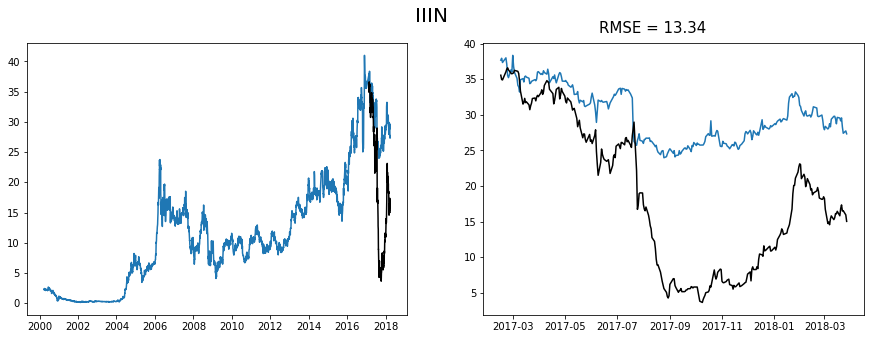

In [11]:
# Calculo la prediccion para mi conjunto test
predicted_stock_price = pd.DataFrame(model.predict(Xtt))

# Junto la grafica de los datos de entrenamiento y test para ver cuanto a variado en terminos generales
indicedetiempo = pd.concat((index_time,index_time_t), axis = 0)
yt = pd.DataFrame(yt) ; ytt = pd.DataFrame(ytt)
stock_real_value = pd.concat((yt,ytt),axis = 0)

# Calculo el RMSE para ver el error de prediccion
rmse = sqrt(mean_squared_error(ytt, predicted_stock_price))

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 5))
fig.suptitle(tickers[index],fontsize = 20)
# Plot de todo el grafico
ax1.plot(indicedetiempo,stock_real_value)
ax1.plot(index_time_t,predicted_stock_price, color = "black")

# Plot de solo la parte que hemos hecho el predict
ax2.plot(index_time_t,ytt)
ax2.plot(index_time_t,predicted_stock_price, color = "black")
ax2.annotate('RMSE = %.2f'% rmse, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)

plt.show()

Mido el RMSE con 200 epocas en diferentes modelos


| Ticket | 10-5-3 | 10-DROP-5,3 | 10-5 | 15-5 | 15-10 |
|--------|--------|-------------|------|------|-------|
| SNCR   | 4.28   | 13.41       | 2.58 | 2.40 | 2.23  |
| USAP   | 16.69  | 12.87       |13.68 |13.40 |18.36  |
| UNFI   | 17.50  | 18.34       |17.10 |17.55 |17.74  |
